<a href="https://colab.research.google.com/github/Lzino/TIL_Today-I-Learned/blob/master/GAN_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generative Adversarial Networks with MNIST

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


In [0]:
# Tensorflow 백엔드 설정 및 랜덤시드 고정
os.environ["KERAS_BACKEND"] = "tensorflow"
np.random.seed(10)
random_dim = 100

In [0]:
# Data loader
def load_mnist_data():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()

  x_train = (x_train.astype(np.float32) -127.5)/127.5

  x_train = x_train.reshape(60000, 784)
  return (x_train, y_train, x_test, y_test)

In [0]:
# Setting optimizer
def get_optimizer():
  return Adam(lr = 0.0004, beta_1 = 0.5)

### Generator

In [0]:
def get_generator(optimizer):
  generator = Sequential()
  generator.add(Dense(256, input_dim = random_dim, kernel_initializer= initializers.RandomNormal(stddev= 0.02)))
  generator.add(LeakyReLU(0.2))

  generator.add(Dense(512))
  generator.add(LeakyReLU(0.2))

  generator.add(Dense(1024))
  generator.add(LeakyReLU(0.2))

  generator.add(Dense(784, activation= 'tanh'))
  generator.compile(loss = 'binary_crossentropy', optimizer = optimizer)
  return generator

### Discriminator

In [0]:
def get_discriminator(optimizer):
  discriminator = Sequential()
  discriminator.add(Dense(1024, input_dim = 784, kernel_initializer= initializers.RandomNormal(stddev = 0.02)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))

  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))

  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))

  discriminator.add(Dense(1, activation= 'sigmoid'))
  discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer)
  return discriminator

### Merging Network

In [0]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
  # Generator와 Discriminator 동시 학습
  discriminator.trainable = False
  # 노이즈 차원 100
  gan_input = Input(shape = (random_dim,))
  # Generator의 결과는 이미지
  x = generator(gan_input)
  # Discriminator의 결과는 True or Fake에 대한 확률값.
  gan_output = discriminator(x)

  gan = Model(input = gan_input, outputs = gan_output)
  gan.compile(loss = 'binary_crossentropy', optimizer = optimizer)
  return gan

In [0]:
# 이미지 출력 함수
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

### Training

In [0]:
def train(epochs =1, batch_size = 128):
  # load data
  x_train, y_train, x_test, y_test = load_mnist_data()
  # batch size
  batch_count = x_train.shape[0]

  # GAN 네트워크 선언
  adam = get_optimizer()
  generator = get_generator(adam)
  discriminator = get_discriminator(adam)
  gan = get_gan_network(discriminator, random_dim, generator, adam)

  for e in range(1, epochs+1):
    print('- ' * 15, 'Epoch %d' % e, '-' * 15)
    for _ in tqdm(range(batch_count)):
      # 입력으로 사용할 random 노이즈와 이미지를 가져오기
      noise = np.random.normal(0,1, size = [batch_size, random_dim])

      image_batch = x_train[np.random.randint(0, x_train.shape[0], size = batch_size)]

      # MNIST 이미지 생성
      generated_images = generator.predict(noise)
      X = np.concatenate([image_batch, generated_images])
      
      y_dis = np.zeros(2*batch_size)
      y_dis[:batch_size] = 0.9
      
      # Discrimianator Training
      discriminator.trainable = True
      discriminator.train_on_batch(X, y_dis)

      # Generator Training
      noise = np.random.normal(0,1, size = [batch_size, random_dim])
      y_gen = np.ones(batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y_gen)

    if e == 1 or e % 20 == 0 :
      plot_generated_images(e, generator)

11493376/11490434 [==============================] - 2s 0us/step






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`
  # Remove the CWD from sys.path while we load stuff.
  0%|          | 0/60000 [00:00<?, ?it/s]

- - - - - - - - - - - - - - -  Epoch 1 ---------------










100%|██████████| 60000/60000 [12:23<00:00, 80.70it/s]


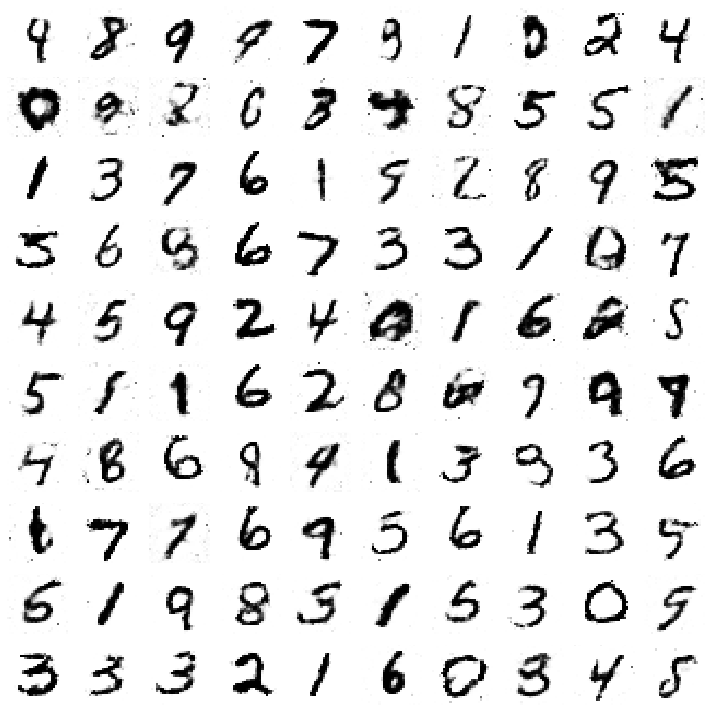

In [10]:
if __name__ == '__main__' :
  train(1, 128) # epoch , batch_size

* code reference : https://www.datacamp.com/community/tutorials/generative-adversarial-networks